In [42]:
# !/usr/bin/python3
# --coding:utf-8--
# @File: Cam_serial.py
# @Author:junru jin
# @Time: 2023年01月 18日10
# @description:
import os
import sys
import argparse
sys.path.append("/mnt/8t/jjr/Structural-DPP-IV")

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from sklearn.metrics import auc, roc_curve, precision_recall_curve, average_precision_score

# from model import StructuralDPPIV
from config import load_config
from config.load_constant import constant
from data import StructuralEncode
from data import Encode
from util import util_draw

config_dict = load_config.load_default_args_dict("StructuralDPPIV")
config_dict['max_epochs'] = 150
config_dict['gpus'] = [3]  # using which GPU to train
config_dict['batch_size'] = 32
config_dict['lr'] = 0.000005
config_dict['model'] = 'StructuralDPPIV'
config_dict['log_dir'] = constant['path_log']
config_dict['max_seq_len'] = 90
args = argparse.Namespace(**config_dict)

class StructuralDPPIV(nn.Module):
    def __init__(self, config):
        super(StructuralDPPIV, self).__init__()
        self.StructEncodeModule = Structural(config)
        self.TextCNN = TextCNN()

        self.classification = nn.Sequential(
            nn.Linear(1024, 64),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
        self.Ws = nn.Parameter(torch.randn(1, 1024).cuda(), requires_grad=True)
        self.Wh = nn.Parameter(torch.randn(1, 1024).cuda(), requires_grad=True)

    def forward(self, x):
        TextCNN_Only = False
        StructuralEncodingOnly = True
        assert not (TextCNN_Only and StructuralEncodingOnly)
        if not TextCNN_Only and not StructuralEncodingOnly:
            TextCNNEncode = self.TextCNN(x[0])
            StructedEncode = self.StructEncodeModule(x[1])
            newEncode = TextCNNEncode * StructedEncode
            output = self.classification(newEncode)
            return output
        elif TextCNN_Only:
            TextCNNEncode = self.TextCNN(x[0])
            output = self.classification(TextCNNEncode)
            return output
        elif StructuralEncodingOnly:
            StructedEncode = self.StructEncodeModule(x)
            output = self.classification(StructedEncode)
            return output


class TextCNN(nn.Module):
    def __init__(self):
        super(TextCNN, self).__init__()
        self.visualization = False
        vocab_size = 24
        dim_embedding = 100
        print(f"[INFO] using CNN config of {dataset_name}")
        # filter_sizes = [1, 2, 4, 8, 16, 24, 32, 48, 64]
        filter_sizes = [1, 2]
        filter_num = 90
        self.embedding = nn.Embedding(vocab_size, dim_embedding)
        self.convs = nn.ModuleList(
            [nn.Conv2d(1, filter_num, (fsz, dim_embedding)) for fsz in filter_sizes])
        self.linear = nn.Linear(filter_num * len(filter_sizes), 1024)

    def forward(self, x):
        # print("\nx = \n", x)
        x = self.embedding(x)
        x = x.view(x.size(0), 1, x.size(1), -1)
        x = [F.relu(conv(x)) for conv in self.convs]

        x = [F.max_pool2d(input=x_item, kernel_size=(x_item.size(2), x_item.size(3))) for x_item in x]
        x = [x_item.view(x_item.size(0), -1) for x_item in x]
        embedding = torch.cat(x, 1)
        embedding = self.linear(embedding)

        return embedding


class Structural(nn.Module):
    def __init__(self, config):
        super(Structural, self).__init__()
        self.config = config
        self.inpuchannel = [32, 32, 64]
        global dataset_name
        dataset_name = 'DPP-IV'
        print(f"[INFO] using Structural config of {dataset_name}")
        self.embedding_dim = 21
        global max_seq_len
        max_seq_len = config.max_seq_len
        self.conv = torch.nn.Conv2d(self.embedding_dim, self.inpuchannel[0], (3, 3), stride=1, padding='same')
        # self.conv = torch.nn.Conv2d(19, self.inpuchannel[0], (3, 3), stride=1, padding='same')
        self.resBlock1 = resBlock(self.inpuchannel[0], self.inpuchannel[1])
        self.resBlock2 = resBlock(self.inpuchannel[1], self.inpuchannel[2], increDimen=True)
        self.linear = nn.Linear(23552, 1024)

    def forward(self, graph):
        # 90 is the max length of sequence, 15 is the number of amino acid, 21 is the number of channel
        graph = graph.cuda()  # (batchSize, 90, 15, 21)
        # graph = graph.transpose(2, 3)  # (batchSize, 90, 21, 15)
        # graph = graph.transpose(1, 2)   # (batchSize, 21, 90, 15)
        representation = self.conv(graph) # (batchSize, 32, 90, 15)
        representation = self.resBlock1(representation) # (batchSize, 32, 90, 15)
        representation = self.resBlock2(representation) # (batchSize, 64, 46, 8)
        representation = representation.flatten(start_dim=1) # (batchSize, 23552)
        representation = self.linear(representation) # (batchSize, 1024)
        return representation


class resBlock(nn.Module):
    def __init__(self, inputchannel, outputchannel, increDimen=False):
        super(resBlock, self).__init__()
        self.increDimen = increDimen
        self.inputchannel = inputchannel
        self.outputchannel = outputchannel
        padding_dim1 = 2 if max_seq_len % 2 == 0 else 1
        self.conv = torch.nn.Conv2d(inputchannel, outputchannel, (3, 3), stride=(2, 2), padding=(padding_dim1, 1))
        self.conv1 = torch.nn.Conv2d(inputchannel, outputchannel, (3, 3), stride=1, padding='same')
        self.batchnorm1 = nn.BatchNorm2d(inputchannel, affine=True)
        self.conv2 = torch.nn.Conv2d(outputchannel, outputchannel, (3, 3), stride=1, padding='same')
        self.batchnorm2 = nn.BatchNorm2d(outputchannel, affine=True)

    def forward(self, feature):
        original = feature

        if self.increDimen:
            feature = F.max_pool2d(input=feature, kernel_size=(2, 2), padding=1)
            original = self.conv(original)
        feature = self.batchnorm1(feature)
        feature = F.relu(feature)
        feature = self.conv1(feature)
        feature = self.batchnorm2(feature)
        feature = F.relu(feature)
        feature = self.conv2(feature)
        feature = feature + original
        return feature


def load_params(model, param_path):
    pretrained_dict = torch.load(param_path)['state_dict']
    # print(pretrained_dict.keys())
    new_model_dict = model.state_dict()
    # print(new_model_dict.keys())
    pretrained_dict = {'.'.join(k.split('.')[1:]): v for k, v in pretrained_dict.items() if '.'.join(k.split('.')[1:]) in new_model_dict}
    # pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if k[6:] in new_model_dict}
    print(pretrained_dict.keys())
    new_model_dict.update(pretrained_dict)
    model.load_state_dict(new_model_dict)

def get_one_sequence_code(sequence = 'YPFPGPIP'):
    # sequence = 'YPFPGPIP'
    Channel = StructuralEncode.convert_to_graph_channel(sequence)
    Structure_data = StructuralEncode.convert_to_graph_channel_returning_maxSeqLenx15xfn(Channel, cubeBiased=False,
                                                                 maxSeqLen=90, cubeBias=False,
                                                                 right_align=False)
    tensor_Structure_data = torch.tensor(Structure_data).cuda()
    tensor_Structure_data = torch.unsqueeze(tensor_Structure_data, 0)
    tensor_Structure_data = tensor_Structure_data.transpose(2, 3)  # (batchSize, 90, 21, 15)
    tensor_Structure_data = tensor_Structure_data.transpose(1, 2)   # (batchSize, 21, 90, 15)

    sequence_data_process = Encode.codePeptides([sequence])
    sequence_data_length = len(sequence_data_process[0])
    sequence_data_padding = np.pad(sequence_data_process[0], (0, 90 - sequence_data_length), 'constant', constant_values=0)
    sequence_data = torch.tensor(np.array([sequence_data_padding])).cuda()

    # print(sequence_data)
    return [sequence_data, tensor_Structure_data]


new_model = StructuralDPPIV(args).cuda()
# load_params(new_model, '/mnt/8t/jjr/Structural-DPP-IV/main/log/StructuralDPPIV/version_3/checkpoints/epoch=73,step=2442,val_SE_epoch=0.95,val_SP_epoch=0.87,val_F1_epoch=0.91,val_AUC_epoch=1.00.ckpt')
load_params(new_model, '/mnt/8t/jjr/Structural-DPP-IV/main/log/StructuralDPPIV/version_4/checkpoints/epoch=60,step=2013,val_SE_epoch=0.97,val_SP_epoch=0.81,val_F1_epoch=0.90,val_AUC_epoch=1.00.ckpt')


[INFO] using Structural config of DPP-IV
[INFO] using CNN config of DPP-IV
dict_keys(['Ws', 'Wh', 'StructEncodeModule.conv.weight', 'StructEncodeModule.conv.bias', 'StructEncodeModule.resBlock1.conv.weight', 'StructEncodeModule.resBlock1.conv.bias', 'StructEncodeModule.resBlock1.conv1.weight', 'StructEncodeModule.resBlock1.conv1.bias', 'StructEncodeModule.resBlock1.batchnorm1.weight', 'StructEncodeModule.resBlock1.batchnorm1.bias', 'StructEncodeModule.resBlock1.batchnorm1.running_mean', 'StructEncodeModule.resBlock1.batchnorm1.running_var', 'StructEncodeModule.resBlock1.batchnorm1.num_batches_tracked', 'StructEncodeModule.resBlock1.conv2.weight', 'StructEncodeModule.resBlock1.conv2.bias', 'StructEncodeModule.resBlock1.batchnorm2.weight', 'StructEncodeModule.resBlock1.batchnorm2.bias', 'StructEncodeModule.resBlock1.batchnorm2.running_mean', 'StructEncodeModule.resBlock1.batchnorm2.running_var', 'StructEncodeModule.resBlock1.batchnorm2.num_batches_tracked', 'StructEncodeModule.resBlock2.

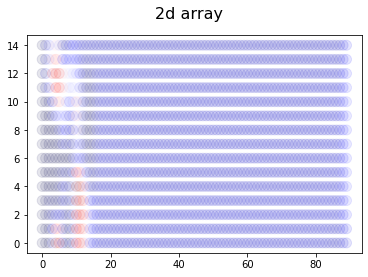

In [44]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, LayerCAM
from util import util_draw
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
class ClassificationTarget:
    def __init__(self,target_category):
        self.target_category = target_category

    def __call__(self, model_output):
        pred_prob_all = F.softmax(model_output, dim=0)
        loss = pred_prob_all[self.target_category]
        return loss


# Targets = [ClassificationTarget(0)]
Targets = [ClassificationTarget(1)]
target_layers = [new_model.StructEncodeModule.resBlock2]
[sequence_code, structual_code] = get_one_sequence_code("YPFPGPIP")

with GradCAMPlusPlus(model=new_model,
             target_layers=target_layers,
             use_cuda=True) as cam:

    grayscale_cam = cam(input_tensor=structual_code,
                        targets=Targets)


util_draw.plot_2d_array(grayscale_cam[0])

In [45]:
def get_one_sequence_cam(sequence, cam_type, class_type, plot_flag=False, target_layers=[new_model.StructEncodeModule.resBlock2]):
    Targets = [ClassificationTarget(class_type)]
    target_layers = target_layers
    [sequence_code, structual_code] = get_one_sequence_code(sequence)
    if cam_type == 'GradCAM':
        CAM = GradCAM
    elif cam_type == 'ScoreCAM':
        CAM = ScoreCAM
    elif cam_type == 'GradCAM++':
        CAM = GradCAMPlusPlus
    elif cam_type == 'AblationCAM':
        CAM = AblationCAM
    elif cam_type == 'XGradCAM':
        CAM = XGradCAM
    elif cam_type == 'LayerCAM':
        CAM = LayerCAM
    else:
        print('cam_type error')
        return
    with CAM(model=new_model,
                 target_layers=target_layers,
                 use_cuda=True) as cam:
        grayscale_cam = cam(input_tensor=structual_code,
                            targets=Targets)
    if plot_flag:
        util_draw.plot_2d_array(grayscale_cam[0], cam_type)
    return grayscale_cam[0]

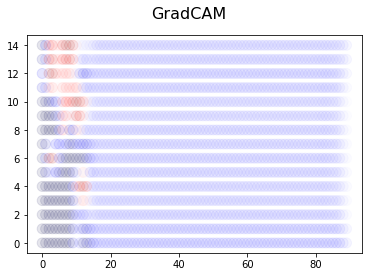

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 339.54it/s]


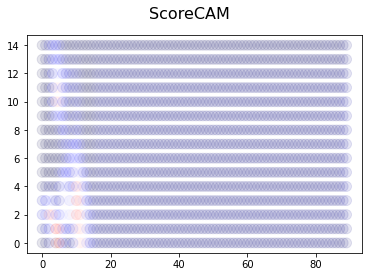

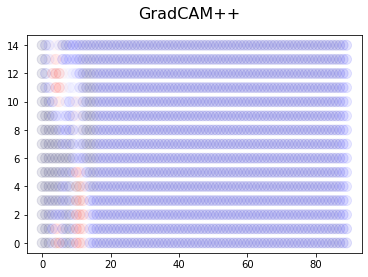

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 201.20it/s]


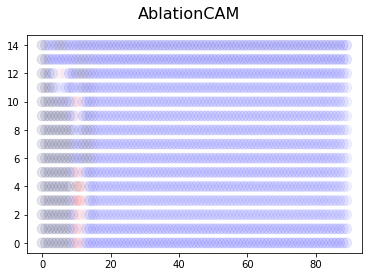

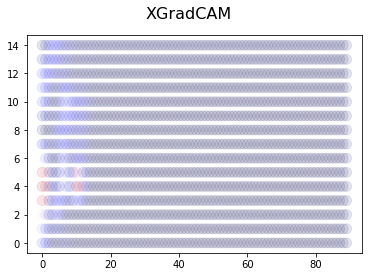

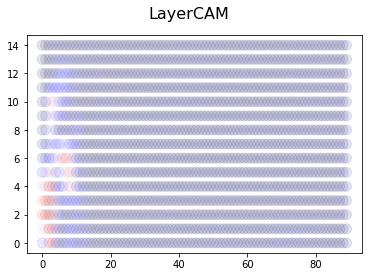

In [46]:
CAM_type = ['GradCAM', 'ScoreCAM', 'GradCAM++', 'AblationCAM', 'XGradCAM', 'LayerCAM']
class_type = 1
plot_flag = True
target_layers = [new_model.StructEncodeModule.resBlock2]
sequence = 'YPFPGPIP'
for cam_type in CAM_type:
    get_one_sequence_cam(sequence, cam_type, class_type, plot_flag, target_layers)